## 📐 Isomap: Theory

### 🎯 Goal
The objective of Isomap is to find a low-dimensional embedding that preserves the **intrinsic geometry** (specifically the **geodesic distances**) of a high-dimensional dataset that is assumed to lie on a low-dimensional manifold.

### 💡 Key Idea
Instead of using straight-line Euclidean distances (which can cut across a "folded" manifold), we approximate **geodesic distances** (distances along the surface). We compute these by finding the shortest paths on a neighborhood graph, then perform classical Multidimensional Scaling (MDS) on that resulting distance matrix.

---

### 🚶 Steps in the Process

1.  **Neighborhood Graph ($G$):** For each point, we connect it to its $k$ nearest neighbors (or all neighbors within a specific radius $r$).
2.  **Graph Shortest Paths:** We compute pairwise shortest-path distances $d_G(i,j)$ on graph $G$ using algorithms like **Dijkstra** or **Floyd–Warshall**. These paths approximate the actual geodesic distances along the manifold.
3.  **Embed with MDS:** We apply classical MDS (double-centering the squared distance matrix and computing eigenvectors) to produce coordinates in $d$ dimensions that best preserve those graph-based distances.



---

### 🔍 Assumptions & Implications

* **Sampling Density:** We assume the manifold is sufficiently sampled and approximately isometric to a convex subset of Euclidean space.
* **Connectivity:** High-quality sampling and a correctly tuned neighborhood size are critical. If $k$ is too small, the graph fragments; if $k$ is too large, we risk "short-circuiting" the manifold.
* **Computational Complexity:** * **Neighbors:** $O(n \log n)$ (approximate).
    * **Shortest Paths:** $O(n^2 \log n)$ or more.
    * **Eigen-decomposition:** $O(n^3)$ worst-case.
    * *Result:* This can be computationally heavy for very large datasets ($n$).

---

### ⚙️ Main Hyperparameters

| Parameter | Function |
| :--- | :--- |
| **`n_neighbors` ($k$)** | Size of the local neighborhood graph. Controls the balance between locality and smoothing. |
| **`n_components`** | The target dimensionality of our embedding (e.g., 2 or 3). |
| **`metric`** | The distance function used to build the initial neighborhood (Euclidean or custom). |
| **`path_method`** | The algorithm used for shortest path approximation (e.g., 'auto', 'FW', 'D'). |
| **`eigen_solver`** | The numerical method for eigen-decomposition (e.g., 'auto', 'arpack', 'dense'). |

## 🚀 Practical Demonstration: Isomap on Digits

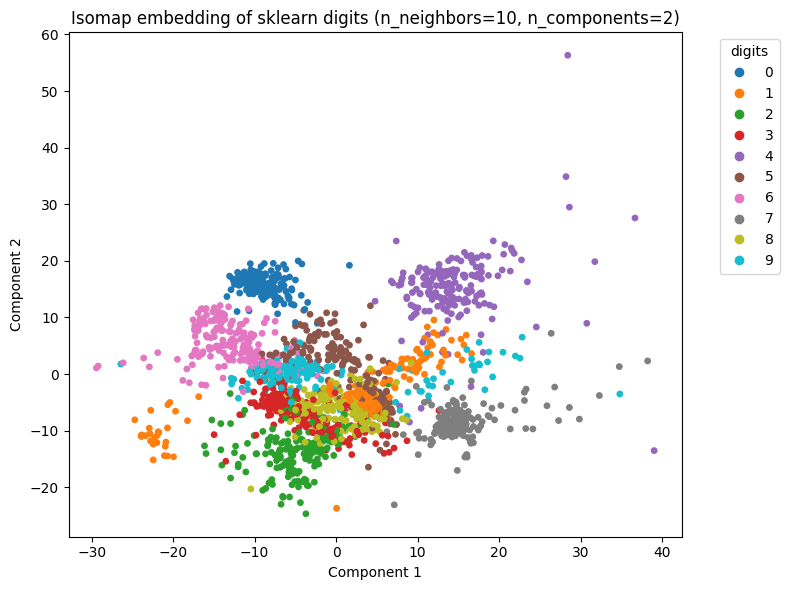

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler

# 1. Load data
digits = load_digits()
X, y = digits.data, digits.target

# 2. Optional: scale features (important when features have different scales)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# 3. Fit Isomap to 2 components
iso = Isomap(n_neighbors=10, n_components=2)
X_iso = iso.fit_transform(Xs)

# 4. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_iso[:,0], X_iso[:,1], c=y, cmap='tab10', s=15)
plt.legend(*scatter.legend_elements(), title="digits", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Isomap embedding of sklearn digits (n_neighbors=10, n_components=2)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


## 📝 Execution Notes & Best Practices

When running Isomap in our environment, we should keep these operational details in mind to ensure the results are reliable.

### 1. The Disconnected Graph Risk
Isomap relies entirely on the connectivity of the neighborhood graph.
* **The Warning:** If we set `n_neighbors` too low, the graph may become disconnected (i.e., some points have no path to others).
* **The Consequence:** In this scenario, `Isomap.fit_transform` may issue a warning or return **NaN distances** for unreachable pairs.
* **The Fix:** We must ensure `n_neighbors` is large enough to maintain a single connected component across the manifold.

### 2. Visual Inspection & Interpretation
We use visualization to validate if the algorithm has captured the intrinsic geometry of our data.
* **Manifold Advantage:** For datasets like **Digits**, Isomap often produces clusters that align with the true class structure significantly better than linear methods like PCA.
* **Structural Detection:** This is because Isomap recognizes that the "distance" between two handwritten digits should be measured along the manifold of possible strokes, not just by pixel-to-pixel subtraction.



---

### 💡 Final Workflow Checklist
1. **Scale the data** (MinMaxScaler or StandardScaler).
2. Start with **`n_neighbors=15`** and increase if connectivity warnings appear.
3. Compare the **2D scatter plot** against PCA to confirm that non-linear manifold learning added value to our analysis.

## 🧪 Pipeline + Hyperparameter Search: Isomap & Logistic Regression

Unlike t-SNE, we can use **Isomap** inside a scikit-learn pipeline because it implements a `transform()` method. This allows us to use cross-validation to find the optimal number of neighbors and components for a downstream classifier.

In [4]:
# Pipeline + hyperparameter search example (sklearn)
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("iso", Isomap()),                 # isomap step (n_neighbors, n_components)
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# Parameter grid for GridSearchCV (small grid)
param_grid = {
    "iso__n_neighbors": [5, 10, 15, 30],
    "iso__n_components": [2, 5, 10, 15],
    "clf__C": [0.01, 0.1, 1.0, 10.0]
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search (accurate but can be slow)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2)
grid.fit(X, y)

print("Best Grid params:", grid.best_params_)
print("Best Grid score:", grid.best_score_)

# Randomized search
from scipy.stats import randint
param_dist = {
    "iso__n_neighbors": randint(3, 40),
    "iso__n_components": randint(2, min(20, X.shape[1])),
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100]
}
rand = RandomizedSearchCV(pipe, param_dist, n_iter=30, cv=cv, scoring="accuracy", n_jobs=-1, random_state=42, verbose=2)
rand.fit(X, y)

print("Best Randomized params:", rand.best_params_)
print("Best Randomized score:", rand.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Grid params: {'clf__C': 10.0, 'iso__n_components': 10, 'iso__n_neighbors': 5}
Best Grid score: 0.968390001552554
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Randomized params: {'clf__C': 1, 'iso__n_components': 17, 'iso__n_neighbors': 17}
Best Randomized score: 0.9666356155876418


## 🛠️ Practical Tips for Hyperparameter Optimization

When running a search for the best Isomap configuration, we should follow these best practices to ensure efficiency and accuracy:

* **Dimensionality Constraints:** We must constrain `n_components` to be less than or equal to the original feature dimension and smaller than the total sample size.
* **Search Strategy:** We use `RandomizedSearchCV` if our search space is large to save time; we use `GridSearchCV` if we want an exhaustive search and have the computational budget.
* **Validation Integrity:** We always use **stratified cross-validation** for classification tasks to preserve class balance across folds.
* **Computational Speed:** We use `n_jobs=-1` to parallelize the search across all available CPU cores, which significantly reduces wait times in Colab.

---

## 🔬 Main Parameters & Their Effects

Understanding the "Bias-Variance" tradeoff within Isomap parameters helps us debug poor model performance.

### 1. `n_neighbors` (k)
* **Small k:** The graph captures very local geometry.
    * **Pros:** Can reveal fine, intricate local structures.
    * **Cons:** The graph may become disconnected, leading to poor geodesic estimates and high sensitivity to noise (Higher Variance).
* **Large k:** The graph approximates more global or Euclidean distances.
    * **Effect:** This creates a smoothing effect that may wash out nonlinear manifold structures (Higher Bias).
* **Practical Tip:** We should try a range between **5–50** depending on our sample size and ensure the graph remains connected.



### 2. `n_components`
* **Too Small:** The embedding cannot capture the manifold's true degrees of freedom, leading to **underfitting** (High Bias).
* **Too Large:** The embedding includes noisy dimensions, leading to **overfitting** (Higher Variance) and redundant data.

### 3. `metric`
* **Standard:** We use the default **Euclidean** distance for most numeric data.
* **Advanced:** If our features have heterogeneous meanings or different scales, we should consider alternative distances like **Mahalanobis** or custom metrics.

### 4. Performance Knobs
* **`eigen_solver` / `tol` / `neighbors_algorithm`:** These are internal performance settings.
* **Recommendation:** Usually, the default values are sufficient for our standard workflows.

## ⚠️ When Isomap Fails: Practical Failure Modes

While Isomap is powerful for capturing intrinsic geometry, it often struggles in the following scenarios:

* **Poor Sampling:** If the manifold is sparsely or non-uniformly sampled, the geodesic approximation becomes inaccurate.
* **Graph Shortcuts / Holes:** If neighborhoods bridge across a "gap" in the manifold, shortest paths may cut through non-manifold regions, leading to incorrect geodesics.
* **Noisy Data:** High noise levels break the local distance geometry, which in turn degrades the geodesic estimates.
* **Self-Intersections:** If a manifold has self-intersections or extreme curvature relative to the sampling rate, the graph distances will be misleading.
* **Disconnected Graphs:** Choosing an `n_neighbors` value that is too small leads to graph fragmentation, making a global embedding impossible.
* **Scalability Constraints:** The computational cost of eigendecomposition and all-pairs shortest paths becomes prohibitive as $N$ reaches tens of thousands.

---

### ⚖️ Bias–Variance Tradeoff for Isomap

We can tune the complexity of our manifold model by adjusting these two primary levers:

| Parameter | Tuning Direction | Effect |
| :--- | :--- | :--- |
| **`n_neighbors`** | **Small** | Focuses on local structure; Lower Bias, Higher Variance (sensitive to noise). |
| | **Large** | Increases smoothing; Higher Bias, Lower Variance. |
| **`n_components`**| **Fewer** | Removes degrees of freedom; Higher Bias, Lower Variance. |
| | **More** | Fits more structure and noise; Lower Bias, Higher Variance. |

> **Strategy:** Tune these using Cross-Validation (CV) based on a downstream supervised metric (like accuracy). Use a **Validation Curve** to identify the point where the model begins to overfit.



---

### ✅ Practical Checklist Before Using Isomap

Before finalizing our pipeline, we should verify each of these steps:

1.  **Scale Features:** Always standardize features if they exist on different scales, as Isomap is distance-based.
2.  **Verify Connectivity:** Ensure the neighborhood graph is fully connected for our chosen `n_neighbors`.
3.  **Sweep Neighbors:** Test a spectrum of values (e.g., `[5, 10, 15, 30, 50]`) and monitor downstream performance.
4.  **Visualize:** Plot 2D or 3D embeddings to gain intuition about the data structure.
5.  **Stratified CV:** Use stratified cross-validation to tune hyperparameters based on task performance, not just reconstruction error.
6.  **Watch Compute Costs:** For large $N$, consider subsampling or using approximate nearest neighbor libraries to save time.
7.  **Compare Baselines:** Always check results against **PCA**, **UMAP**, or **t-SNE**. Sometimes a simpler linear PCA performs just as well.

---

### 🔄 Alternatives to Consider
If Isomap results are unsatisfactory, we can pivot to:
* **LLE (Locally Linear Embedding):** If local linearity is a valid assumption.
* **UMAP / t-SNE:** More robust to noise and significantly faster for large datasets.
* **Autoencoders:** For very large datasets requiring a learned, non-linear mapping.

# 🏁 Comparative Summary: PCA vs. Isomap vs. UMAP

We use this guide to choose the right tool for our data, balancing linear simplicity with non-linear complexity.

---

## 1. Core Idea & Mathematical Backbone

| Method | Core Objective | Mathematical Backbone | One-Line Intuition |
| :--- | :--- | :--- | :--- |
| **PCA** | Preserve max variance via linear projections. | SVD of covariance matrix. | *"The Straight Ruler"* |
| **Isomap** | Preserve global geodesic distances on a manifold. | k-NN graph → shortest paths → MDS. | *"Unroll the manifold"* |
| **UMAP** | Preserve local neighborhoods + global layout. | Fuzzy simplicial sets + cross-entropy. | *"Keep friends close, enemies far"* |

---

## 2. Structure & Property Preservation

| Property | PCA | Isomap | UMAP |
| :--- | :---: | :---: | :---: |
| **Linear Structure** | ✅ Excellent | ❌ Poor | ❌ Poor |
| **Global Geometry** | ⚠️ Limited | ✅ Strong | ⚠️ Moderate |
| **Local Neighborhoods** | ❌ Poor | ⚠️ Limited | ✅ Excellent |
| **Non-linear Manifolds** | ❌ Poor | ✅ Strong | ✅ Strong |
| **Cluster Separation** | ❌ Poor | ⚠️ Limited | ✅ Excellent |
| **Interpretability** | ✅ High | ⚠️ Medium | ❌ Low |



---

## 3. Bias–Variance & Scalability

### **PCA: High Bias, Low Variance**
* **Intuition:** Cannot model non-linear structure (systematic underfitting) but is extremely stable across datasets.
* **Scalability:** ✅ Excellent ($O(min(n^3, d^3))$).

### **Isomap: Medium Bias, Medium Variance**
* **Intuition:** Sensitive to `n_neighbors`; can overfit if the graph is poorly constructed.
* **Scalability:** ❌ Poor for large $n$ ($O(n^2 \log n)$ + eigendecomposition).

### **UMAP: Low Bias, Higher Variance**
* **Intuition:** Strongly data-dependent; stochastic nature means different runs may differ slightly.
* **Scalability:** ✅ Very Good ($O(n \log n)$).

---

## 4. Decision Table: When to Use Which?

| Use Case | Best Choice | Why? |
| :--- | :--- | :--- |
| **ML Feature Compression** | **PCA** | Fast, stable, and prevents overfitting. |
| **Noise Reduction** | **PCA** | Linear signal recovery. |
| **Manifold with Global Geometry** | **Isomap** | Preserves "real" distances along the surface. |
| **Visualization (2D/3D)** | **UMAP** | Superior cluster separation and aesthetics. |
| **Cluster Discovery** | **UMAP** | Groups similar points aggressively. |
| **Production Pipelines** | **PCA / Isomap** | High stability and `.transform()` support. |

---

## ⚠️ Failure Modes (Real-World "Gotchas")

* **PCA fails when:** The manifold is non-linear (like a Swiss Roll) or when the highest variance isn't the most important signal for classification.
* **Isomap fails when:** The graph becomes disconnected or "short-circuits" across manifold holes; it struggles with very noisy or massive datasets.
* **UMAP fails when:** We need strict metric faithfulness (distances aren't literal) or reproducibility without a fixed seed. It can also be dangerous if used blindly for modeling without validation.

---

### 💡 Final Interview-Ready Summary
* **PCA** is a linear variance-preserving method with high bias and low variance.
* **Isomap** is a non-linear manifold learner that preserves global geodesic distances but is sensitive to neighborhood construction.
* **UMAP** is a stochastic, topological method that excels at local structure and visualization, but sacrifices metric interpretability and stability.